# Exploratory data analysis on London Data

This notebook will serve for exploring the London Dataset and gainging insight on how to process it 

First, we recuperate the necessary packages 

In [150]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The data is divided in 163 datasets of 1 million entries.

We upload the data from several csv file and merge them together

In [151]:
df = pd.read_csv("../Data/Londondata/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv")

Add as many datasets as needed

In [152]:
for i in range(2,4): 
    dataframe = pd.read_csv(r"../Data/Londondata/Power-Networks-LCL-June2015(withAcornGps)v2_"+str(i)+".csv")
    df = df.append(dataframe)

In [153]:
df.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0,ACORN-A,Affluent
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0,ACORN-A,Affluent
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0,ACORN-A,Affluent
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0,ACORN-A,Affluent
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0,ACORN-A,Affluent


The data ranges from 2012 to 2014, we will keep the data from 2013

In [154]:
#Get the year of observation
df["year"] = pd.to_datetime(df["DateTime"]).dt.year
df.index = df.index - 3840


#Isolate the year 2013
df = df[df["year"] == 2013]

Mak the usage be floats rather than strings

In [155]:
#Get rid of Null values
df["KWH/hh (per half hour) "] = df["KWH/hh (per half hour) "].replace('Null',np.nan)

#Get values as float
df["KWH/hh (per half hour) "] = pd.to_numeric(df["KWH/hh (per half hour) "], downcast="float")


Lets look at how many data points there is for each households (LCLid) for the 2013 year

In [156]:
df.groupby("LCLid")['KWH/hh (per half hour) '].apply(lambda x: len(x))

LCLid
MAC000002    17532
MAC000003    17530
MAC000004    17531
MAC000006    17532
MAC000007    17529
MAC000008    14505
MAC000009    17523
MAC000010    17532
MAC000011    17531
MAC000012    17531
MAC000013    17531
MAC000016      721
MAC000018    17532
MAC000019    17532
MAC000020    17530
MAC000021    17531
MAC000022    17531
MAC000023    17531
MAC000024    17531
MAC000025    17526
MAC000026    17519
MAC000027    17532
MAC000028    13401
MAC000029    17520
MAC000030    17523
MAC000032    17531
MAC000033    17531
MAC000034    17528
MAC000035    17530
MAC000036    17531
             ...  
MAC000066    17530
MAC000067    17530
MAC000068    17520
MAC000069    17529
MAC000070    17530
MAC000072    17531
MAC000073    17517
MAC000074    17526
MAC000077    17531
MAC000078    17531
MAC000079    17050
MAC000080     7108
MAC000081    17529
MAC000083    17531
MAC000084    17531
MAC000085    17531
MAC000086    17531
MAC000087    17529
MAC000089    17531
MAC000090    17529
MAC000091    17532
MAC000

We can see that most Households have around 17530 entries, which makes sens as there are 17520 half hours in a year

Some are however far from this value. As we have plenty of data, lets delete all Household with less than 17520 data points


In [157]:
groups = df.groupby("LCLid")['KWH/hh (per half hour) '].apply(lambda x: len(x))
groups = groups[groups>17520]

ind = groups.index

df = df[df["LCLid"].isin(ind)]

In [158]:
len(ind)

67

We now have 67 households (this is easily modulable by calling more datasets at the beginning) 

We however have more data points than half hours. Lets identify how. It can be some repeated half hour. Lets test for this on one household

In [159]:
house1 = df[df["LCLid"] == "MAC000036"]
house1[house1.duplicated()]
house1.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped,year
-1266,MAC000036,Std,2013-01-01 00:00:00.0000000,0.006,ACORN-E,Affluent,2013
-1265,MAC000036,Std,2013-01-01 00:30:00.0000000,0.017,ACORN-E,Affluent,2013
-1264,MAC000036,Std,2013-01-01 01:00:00.0000000,0.059,ACORN-E,Affluent,2013
-1263,MAC000036,Std,2013-01-01 01:30:00.0000000,0.000,ACORN-E,Affluent,2013
-1262,MAC000036,Std,2013-01-01 02:00:00.0000000,0.000,ACORN-E,Affluent,2013


There is indeed some duplicates. Lets drop them

In [160]:
house1.drop_duplicates(inplace = True)
len(house1)

C:\Users\Kirsch\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


17519

We now have a normal number of values. There is just one value missing, which will be taken care of afterwards. First, lets modify the whole dataset

In [163]:
df.drop_duplicates(inplace = True)

print(len(df)/67)

17517.985074626864


The average number of data points per households is now 1717, which is much better. It is however below the 17520 half hours. Lets find which half hours are missing and include them with a nan reading

In [165]:
year = pd.date_range("01/01/2013 00:00.0000000", "31/12/2013 23:30.0000000", freq="30min")

d = [None]*len(ind)
add = [None]*len(ind)
for i in range(len(ind)):
    d[i] = df[df["LCLid"] == ind[i]]
    r = pd.to_datetime(d[i]["DateTime"])
    years = [x.strftime("%Y-%m-%d %H:%M:%S") for x in year]
    r = [x.strftime("%Y-%m-%d %H:%M:%S") for x in r]
    main_list = np.setdiff1d(list(years),list(r))

    add[i] = pd.DataFrame({"LCLid":ind[i], "DateTime": main_list,"KWH/hh (per half hour) ": np.nan, 'Acorn': "ACORN-A",
                          "Acorn_grouped": "Affluent", "year": 2013,'stdorToU': "Std"})

    df = df.append(add[i])
df = df.sort_values(['LCLid', 'DateTime'])

df = df.reset_index(drop = True)



In [167]:
print(len(df)/len(ind))

17520.0


We now have the right number of data for each households. We however need to change the granularity of the data, for it to match the South African data 

In [189]:
df.index= pd.DatetimeIndex(df["DateTime"])
df = df.drop(["DateTime"], axis = 1)
df.head()

,Acorn,Acorn_grouped,KWH/hh (per half hour),LCLid,stdorToU,year
DateTime,,,,,,
2013-01-01 00:00:00,ACORN-A,Affluent,0.219,MAC000002,Std,2013
2013-01-01 00:30:00,ACORN-A,Affluent,0.241,MAC000002,Std,2013
2013-01-01 01:00:00,ACORN-A,Affluent,0.191,MAC000002,Std,2013
2013-01-01 01:30:00,ACORN-A,Affluent,0.235,MAC000002,Std,2013
2013-01-01 02:00:00,ACORN-A,Affluent,0.182,MAC000002,Std,2013


In [208]:
df[df['KWH/hh (per half hour) '].isnull()]
df["2013-03-26 21:00:00"]

,Acorn,Acorn_grouped,KWH/hh (per half hour),LCLid,stdorToU,year
DateTime,,,,,,
2013-03-26 21:00:00,ACORN-A,Affluent,0.100,MAC000002,Std,2013
2013-03-26 21:00:00,ACORN-P,Adversity,0.253,MAC000003,Std,2013
2013-03-26 21:00:00,ACORN-E,Affluent,0.000,MAC000004,Std,2013
2013-03-26 21:00:00,ACORN-Q,Adversity,0.087,MAC000006,Std,2013
2013-03-26 21:00:00,ACORN-H,Comfortable,0.322,MAC000007,Std,2013
2013-03-26 21:00:00,ACORN-L,Adversity,0.128,MAC000009,Std,2013
2013-03-26 21:00:00,ACORN-H,Comfortable,0.626,MAC000010,Std,2013
2013-03-26 21:00:00,ACORN-N,Adversity,0.831,MAC000011,Std,2013
2013-03-26 21:00:00,ACORN-E,Affluent,0.283,MAC000012,Std,2013


In [211]:
df_hour = df[df["LCLid"] == ind[0]]
df_hours = df_hour.resample('H').apply(lambda x: x.values.sum())
df_hours["Acorn"] = df_hour["Acorn"]
df_hours["Acorn_grouped"] = df_hour["Acorn_grouped"]
df_hours["LCLid"] = ind[0]
df_hours['stdorToU'] = df_hour['stdorToU']
df_hours['year'] = df_hour['year']


for i in range(1, len(ind)):
    df_hour1 = df[df["LCLid"] == ind[i]]
    df_hours1 = df_hour1.resample('H').apply(lambda x: x.values.sum())
    df_hours1["Acorn"] = df_hour1["Acorn"]
    df_hours1["Acorn_grouped"] = df_hour1["Acorn_grouped"]
    df_hours1["LCLid"] = ind[i]
    df_hours1['stdorToU'] = df_hour1['stdorToU']
    df_hours1['year'] = df_hour1['year']

    
    df_hours = df_hours.append(df_hours1)
    
df_hours = df_hours.sort_values(['LCLid','DateTime'])

8760.0


Acorn                        0
Acorn_grouped                0
KWH/hh (per half hour)     117
LCLid                        0
stdorToU                     0
year                         0
dtype: int64

We now have a dataset of the right number of entries for each household. 

Lets now study the distribution for each household, to see how it differs from one to another 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 <a list of 67 Text xticklabel objects>)

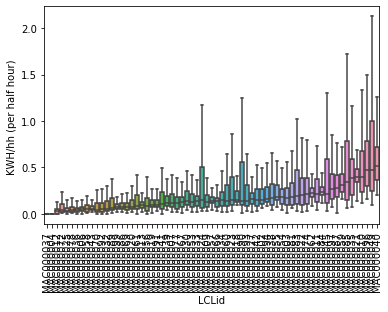

In [196]:
import seaborn as sns
fig, ax = plt.subplots()
order = df_hours.groupby(by="LCLid").median().sort_values(by="KWH/hh (per half hour) ", ascending=True).index
g = sns.boxplot(x="LCLid", y="KWH/hh (per half hour) ", data=df, showfliers=False, order=order)

plt.xticks(rotation=90)